# Section 2. Julia Without Tears: Types
#### Author: Bruno Cavani

---

Against its peers, Julia has a very rich type system and it is quite easy to declare even new types. For those who want to dig into this subject, [Julia Documentation](https://floswald.github.io/NumericalMethods/lecture2-types/) is a complete material.

## 2.1. Base Type System

One of the more useful types in Julia is `Number`, and the following Wikipedia figure is a diagrammatic way to describe it.

Although it is not shown, one could think as the `Number` type being a subtype of `Any` datatype, which is everyone's great-grandmother.

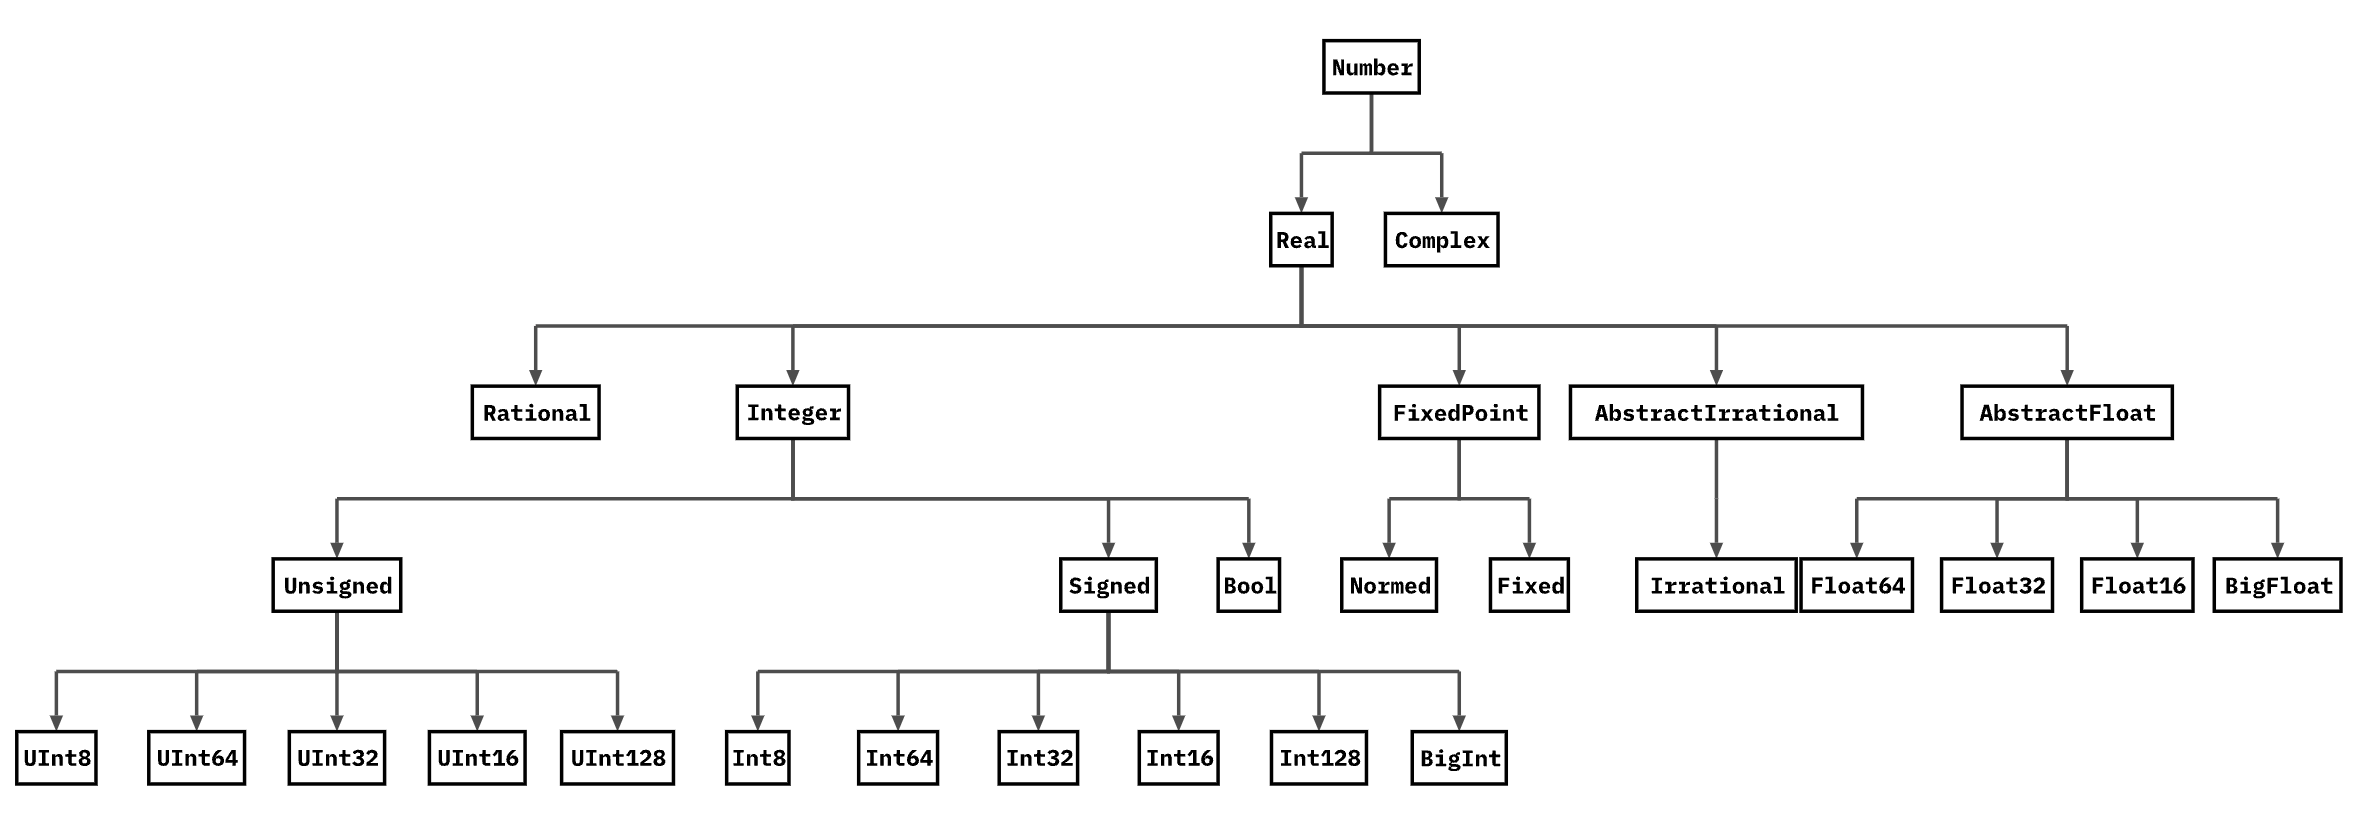

In [1]:
display("image/png", read("Juliatypes.png"))

Whether one wants to investigate the successors and predecessors of any type, `subtypes` and `supertypes` can be useful functions. The following example along with the image may be thoughtful.

In [2]:
subtypes(Integer)

3-element Vector{Any}:
 Bool
 Signed
 Unsigned

In [3]:
supertypes(Integer)

(Integer, Real, Number, Any)

## 2.2 Defining New Types

A fair-first question is *why should we define new types*. Even though Julia carries out a bunch of them, precisely defining a new type can be helpful depending on your project.

The following example may motivate the reader. Recall from your Math classes that a pair of numbers can represent a variety of elements, for example (i) a vector $x \in \mathbb{R}^2$, (ii) a complex number $c \in \mathbb{C}$ or (iii) a tuple informing about the width and height of a rectangle.

In [4]:
x = (3,4) # vector
c = (3,4) # complex number, 3 + 4i
rectangle = (3,4) # (width, height)


(3, 4)

but note that, unless we explicitly comment their representations, it would not be possible to distinguish them, since

In [5]:
x == c == rectangle

true

as that is clearly a problem.

For example, we would like to have a function `width` that returns the width of a rectangle, but it makes no sense to apply that to a complex number.

In other words, it would be useful to propose a way to distinguish between different *types* of objects with different *behaviours*. 

In this sense, the keyword `struct` (short for *structure*) tells Julia that we are defining a new type. We list the field names together with **type annotations** using `::` that specify which type each field can contain.

In [6]:
struct Rectangle
    width :: Float64
    height :: Float64
end

Once Julia has this template, we can create objects which have that type as follows:

In [7]:
r = Rectangle(3,4)

Rectangle(3.0, 4.0)

where the function `Rectangle` with identical name to our type is called a **constructor**.

As we did earlier, we can check that `r` is now a variable whose type is `Rectangle`, in other words `r` is a `Rectangle`:

In [8]:
typeof(r)

Rectangle

equivalently

In [9]:
r isa Rectangle

true

Hence, one can extract from `r` the information about the values of the fields that it contains using `.`:

In [10]:
r.width

3.0

In [11]:
r.height

4.0

Types like this are often called **composite types**. They consist of aggregating, or collecting together, different pieces of information that belong to a given object.

### 2.2.1. Immutable *versus* Mutable

Now suppose we want to change the width of `r`. An natural alternative would be to try the following:

In [12]:
r.width = 10

ErrorException: setfield!: immutable struct of type Rectangle cannot be changed

however, Julia complains that fields of objects of type `Rectangle` *cannot* be modified. This is because `struct` makes **immutable** objects. The reason for this is that these usually lead to faster code.

If we really want to have a **mutable** object, we can declare it using `mutable struct` instead of `struct` – try it!

## 2.3. Functions on Types

We can now define functions that act only on given types. To restrict some *function argument* to only accept objects of a certain type, we add a type annotation, that is,


In [13]:
width(r::Rectangle) = r.width

width (generic function with 1 method)

where we allow the function `width` to be applied solely on `Rectangle` objects:

In [14]:
width(r)

3.0

and if you try over non-`Rectangle`, it will naturally pin down an error.

It is common in Julia to have *generic* versions of functions that apply to any object, and then specialised versions that apply only to certain types.

For example, we might want to define an `area` function with the correct definition for `Rectangles`, but it might be convenient to fall back to a version that just returns the value itself for any other type:

In [15]:
# two different function bodies for the same function name!
area(r::Rectangle) = r.width * r.height
area(x) = x

area (generic function with 2 methods)

In [16]:
area(r)

12.0

In [17]:
area(1)

1

However, note that allowing for such a generic function can be useless in the sense of it can be applied to literally any object, such as

In [18]:
area("Julia's learning goes smoothly well with a bit of Brazilian samba")

"Julia's learning goes smoothly well with a bit of Brazilian samba"

whose output may be curious (try this!), but the application is certainly poor.

Note that these are different versions of a function with the name, each version acting on different types is called a **method** of the generic function.

Suppose that later we create a `Circle` type. We can then just add a new method `area(c::Circle)` with the corresponding definition, and Julia will continue to choose the correct version (method) when we call `area(x)`, depending on the type of `x`.

### 2.3.1. Multiple Dispatch

The act of choosing which function to call based on the type of the arguments that are passed to the function is called **dispatch**.

A central feature of Julia is **multiple dispatch**: this choice is made based on the types of *all* the arguments to a function.

For example, the following three calls to the `+` function each call different methods, defined in different locations.

In [19]:
cc = 3 + 4im

3 + 4im

In [20]:
cc + cc

6 + 8im

where `+` plays the role of a generic function

In [21]:
+

+ (generic function with 208 methods)

but we can dispatch its methods as in

In [22]:
@which cc + cc

+(z::Complex, w::Complex) in Base at complex.jl:288

In [23]:
@which cc + 1

+(z::Complex, x::Real) in Base at complex.jl:326

In [24]:
@which 1 + cc

+(x::Real, z::Complex) in Base at complex.jl:325

## 2.3. A WorkerSpell Type

Let us take a look at something that can be even more useful.  In Lentz et al. (2018), they analyse data on worker spells at firms, managing a dataset of $4,000,000$ workers and $400,000$ firms.

Namely, *spell* is a period of time that a worker spent at a certain firm, earning a certain wage.

Hence, they denote

* $i \equiv$ worker ID
* $j \equiv$ firm ID
* $w_i \equiv$ vector of wages for each year in the spell
* $D_{it} \equiv$ indicator whether the worker changes firm after this spell

for which they have a likelihood function to estimate which encodes for worker *i* the likelihood of observing the data

\begin{align*} 
\left(w_{it},j_{it},x_{it}\right)_{t=1}^T
\end{align*}

Simplifying a bit, this looks for worker *i* like

\begin{align*}
L_{i}=\Pi_{t=1}^{T_{i}} f\left(w_{i t} \mid j_{i t}, x_{i t}\right) \times \Pi_{t=1}^{T_{i}} S\left(i, j_{i t}, x_{i t}\right)^{1-D_{i t}} M\left(j^{\prime} \mid i, j_{i t}, x_{i t}\right)^{D_{i t}}
\end{align*}

but note that $T_i$ plays an important role here, since different workers have differently long spells.

### 2.3.1. Defining a Spell

In [25]:
using Dates

In [26]:
mutable struct Spell 
	start       :: Date # start date
	stop        :: Date # end date
	duration    :: Week # spell duration
	firm        :: Int   # ∈ 1, 2, ..., L+1
	wage        :: Float64 # wage value
	change_firm :: Bool  # switch firm after this spell?
	function Spell(t0::Date,fid::Int)  # this is the "inner constructor" method
		this = new()
		this.start = t0
		this.stop = t0
		this.duration = Week(0)
		this.firm = fid
		this.wage = 0.0
		this.change_firm = false
		return this 
	end
end

Let's create one of those:

In [27]:
sp = Spell(Date("2015-03-21"), 34)

Spell(Date("2015-03-21"), Date("2015-03-21"), Week(0), 34, 0.0, false)

and now we need a way to set some infos on this type. In particular, we want to record the wage the worker got, and how long the spell lasted.

A function to call at the end of a spell can perform as the following:

In [28]:
function finish!(s::Spell,w::Float64,d::Week)
    @assert d >= Week(0)
    s.stop = s.start + d
    s.duration = d
    s.wage = w
end

finish! (generic function with 1 method)

For example, assume that a particular spell lasted for 14 weeks and was characterised by a wage of 100.1 dollars, then

In [29]:
finish!(sp, 100.1, Week(14))

100.1

thus, we now get

In [30]:
sp

Spell(Date("2015-03-21"), Date("2015-06-27"), Week(14), 34, 100.1, false)

where the spell seems to be well-defined, now let us deal with the worker.

### 2.3.2. Defining the Workers

Now, we define the workers, who accumulate `Spells`.

In [31]:
mutable struct Worker
    id :: Int  # worker name, ID
    T  :: Int  # number of weeks observed
    l  :: Int  # current firm ∈ 1, 2, ..., L+1
    spells :: Vector{Spell}  # an array of type Spell
    function Worker(id,T,start::Date,l::Int)
        this = new()
        this.id = id
        this.T = T 
        this.l = l
        this.spells = Spell[Spell(start,l)]
        return this
    end
end

Hence, we can create a worker and make him work at a new firm:

In [32]:
w0 = Worker(13, 18, Dates.today(), 3)

Worker(13, 18, 3, Spell[Spell(Date("2022-06-17"), Date("2022-06-17"), Week(0), 3, 0.0, false)])

and let's say that first spell lasts for 15 weeks at 500 dollars per week

In [33]:
finish!(w0.spells[end], 500.0,  Week(15))

500.0

finally,

In [34]:
w0.spells

1-element Vector{Spell}:
 Spell(Date("2022-06-17"), Date("2022-09-30"), Week(15), 3, 500.0, false)

### 2.3.3. Likelihood Function

In order to evaluate the function $L_i$ above, we need to sum over each workers $T_i$ weeks of work, i.e.

In [35]:
# defining the number of workers and firms, respectively,
N = 5
F = 2

2

In [36]:
# building up each worker history
starts = rand(Date(2014,1,29):Week(1):Dates.today(),N)
Ts = rand(5:10,N)
js = rand(1:F,N)
wrks = [Worker(id,Ts[id],starts[id],js[id]) for id in 1:N]

5-element Vector{Worker}:
 Worker(1, 9, 1, Spell[Spell(Date("2016-01-13"), Date("2016-01-13"), Week(0), 1, 0.0, false)])
 Worker(2, 9, 2, Spell[Spell(Date("2014-02-19"), Date("2014-02-19"), Week(0), 2, 0.0, false)])
 Worker(3, 6, 1, Spell[Spell(Date("2020-12-16"), Date("2020-12-16"), Week(0), 1, 0.0, false)])
 Worker(4, 10, 1, Spell[Spell(Date("2016-05-11"), Date("2016-05-11"), Week(0), 1, 0.0, false)])
 Worker(5, 6, 2, Spell[Spell(Date("2014-04-30"), Date("2014-04-30"), Week(0), 2, 0.0, false)])

but note that we did not set wages to the workers.

We can do it assuming that with probability 0.5 they have 2 spells:

In [37]:
using Distributions

In [38]:
Ln = LogNormal(1.0,	0.1)

LogNormal{Float64}(μ=1.0, σ=0.1)

In [39]:
# an empty array of type worker
dates = Date(2014,1,29):Week(1):Dates.today()
workers = Worker[]
for iw in 1:N
    w = Worker(iw,rand(5:10),rand(dates),rand(1:F))
    dur = 0 # start with zero weeks
    for tx in 1:w.T
        dur += 1 # increase duration
        if rand() < 0.5
            # switches to another firm
            finish!(w.spells[end], rand(Ln), Week(dur))
            dur = 0 # reset duration
            w.spells[end].change_firm = true
            # new spell starts on the same day!
            newfirm = rand(1:F)
            push!(w.spells, Spell(w.spells[end].stop,newfirm))
            w.l = newfirm
        else
            # nothing to record: stay at same firm
        end
        if tx == w.T
            # finish last spell
            finish!(w.spells[end], rand(Ln), Week(dur))
        end
    end
    push!(workers,w)
end

In [40]:
workers

5-element Vector{Worker}:
 Worker(1, 8, 1, Spell[Spell(Date("2014-09-24"), Date("2014-10-01"), Week(1), 2, 2.6044221097866425, true), Spell(Date("2014-10-01"), Date("2014-10-29"), Week(4), 2, 2.439095355634621, true), Spell(Date("2014-10-29"), Date("2014-11-05"), Week(1), 1, 2.921738099545617, true), Spell(Date("2014-11-05"), Date("2014-11-12"), Week(1), 1, 3.0029845735263785, true), Spell(Date("2014-11-12"), Date("2014-11-19"), Week(1), 1, 2.3724044785896963, false)])
 Worker(2, 9, 1, Spell[Spell(Date("2015-12-09"), Date("2015-12-16"), Week(1), 2, 3.230713589749736, true), Spell(Date("2015-12-16"), Date("2016-01-06"), Week(3), 2, 2.5325038889487996, true), Spell(Date("2016-01-06"), Date("2016-01-13"), Week(1), 2, 2.7679557711022524, true), Spell(Date("2016-01-13"), Date("2016-02-10"), Week(4), 1, 2.6939100430816256, false)])
 Worker(3, 9, 2, Spell[Spell(Date("2021-04-28"), Date("2021-05-05"), Week(1), 1, 2.28906878183093, true), Spell(Date("2021-05-05"), Date("2021-05-19"), Week(2), 1

Therefore, we can then iterate over our array of workers like the following:

In [41]:
L0 = 0.0
for iw in workers
	# loops over multiple spells
	# for each worker
	for (idx, sp) in enumerate(iw.spells)
		L0 += logpdf(Ln, sp.wage)
	end						
end

In [42]:
L0

-5.268787941103593